## Activation Functions and Humanizing Computational Decision Making

In this notebook, we direct our attention toward a simple yet profound question which turns out to be quite rich in depth and which ultimately serves at motivation for our discussion with respect to neural networks: 

_How do we make decisions?_

Attempts to answer this question in a meaningful way have yielded rich fields of research in disciplines as diverse as biology, philosophy, computational science, and many others. These results have led to Nobel Prizes, Fields Medals, and influence - if not directly control - many facets of our current life as we know it today. As mathematicians, we will of course choose to ignore many of these results and instead direct our attention toward a drastically oversimplified model which we will in turn incrementally build into something vaguely resembling a working decision-making machine.

### Software Prerequisites

The following Python libraries are prerequisites to run this notebook; simply run the following code block to install them. They are also listed in the `requirements.txt` file in the root of this notebook's [GitHub repository](https://github.com/uccs-math-clinic/mc-workshops).

In [1]:
%pip install matplotlib==3.5.1 \
             numpy==1.21.5

You should consider upgrading via the '/work/jonathan/uccs/mc-workshops/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The Python kernel must be restarted after running the above code block for the first time within a particular virtual environment. This may be accomplished by navigating to `Kernel -> Restart` in the menu bar.

With our package dependencies installed, we can run the following cell in order to import the packages needed for this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib notebook
plt.ion()

## Simple Decisions

When developing any useful model, it serves one well to examine the simplest possible non-trivial case, characterize that case fully, and incrementally introduce complexity from there. In our case - wherein we are looking for a mathematical formulation of decision-making - we will begin by examining in generality decisions which admit either a "yes" response or a "no" response. As it turns out, a great many useful decisions can be made by composing such simple yes/no decisions; in fact, classical computing as we know it today is entirely built upon such yes/no (or more accurately "binary") logic.

To that end, suppose that we have a set of data along with a question for which we hope to answer "yes" or "no" about. As a very simple example, suppose that we are art museum curators and are tasked with assembling a collection of "light" themed paintings. To this end, we might assemble a collection of grayscale paintings and based on the total composition of light paints used in the piece, we may either choose to include it in our collection or not. The decision we must make is whether to include a particular work of art in the collection; in other words, if a painting contains enough light paint, the decision we make is "yes" and if it does not, then the answer is "no".

A function which encodes such logic is called an _activation function_. Activation functions take as input some characteristic of a particular data point (in our example, the amount of "light" paint used in a particular piece) and output a particular decision (in our example, whether a particular painting should be included in the themed collection). Perhaps the simplest possible example of such a function might be a step function which outputs `1` ("yes") if the input is above a particular threshold $x_0$, and `0` ("no") if the function is below that threshold:

$$
f(x) = \begin{cases} 
      0 & x \leq x_0 \\
      1 & x > x_0 
\end{cases}
$$

Such a function is called a _binary activation_ function and is simply a shifted [Heaviside function](https://en.wikipedia.org/wiki/Heaviside_step_function). Given a particular set of data, such a function would classify that data as follows:

In [3]:
def binary_classify(x, x_0):
    # We code our classification function manually for pedagogical reasons,
    # but point out two equally valid and more elegant ways of performing the
    # same task.
    
    # We create a new list to hold our classification results, which for a particular
    # element of x contains 1 for "yes" or 0 for "no".
    #
    classification_values = []
    
    # Iterate through each value in x and add the corresponding classification result
    # to the list of classification values.
    #
    for x_i in x:
        if x_i > x_0:
            classification_values.append(1)
        else:
            classification_values.append(0)
            
            
    return classification_values

    # The following is the same code, but utilizes numpy's Heaviside function to
    # perform all classification in one line of code.
    #
    #return np.heaviside(x, x_0)
    
    # The following line is equivalent to the above, but utilizes Python list
    # comprehensions to make the classification a bit more elegant.
    #
    #return [(1 if x_i > x_0 else 0) for x_i in x]
    
# Now let's try it out! Let's say that we want to output 1 if a particular element is
# more than 4, and 0 otherwise.
#
# We'll test a few values against this.
#
test_data = [0, 5, 7, 2]
print('Decisions for {}: {}'.format(test_data, binary_classify(test_data, 4)))

Decisions for [0, 5, 7, 2]: [0, 1, 1, 0]


### Visualizing the Decision

To see what a set of decisions might look like with respect to a particular set of input data, we plot the decision function below along with the set of points which represent a decision made for a particular value of $x$. Green dots represent a "yes" decision, and red dots represent a "no" decision.

<IPython.core.display.Javascript object>


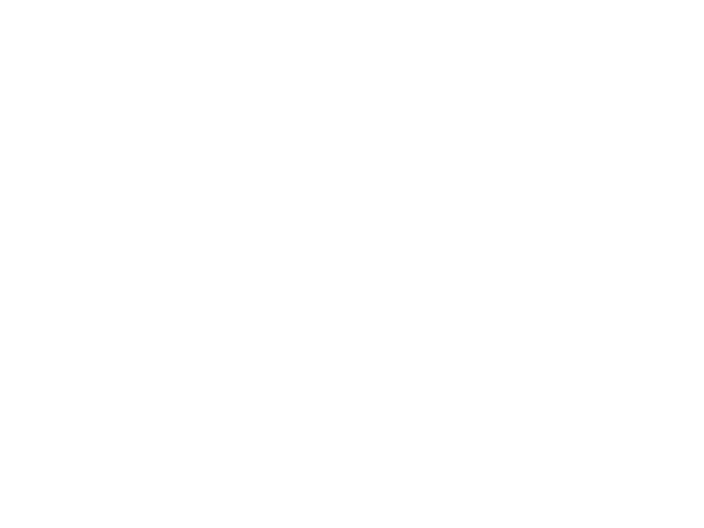

In [4]:
binary_endpoints = (-5, 5)
binary_center = 3
binary_test_values = np.linspace(binary_endpoints[0], binary_endpoints[1], 20) 
binary_decisions = binary_classify(binary_test_values, binary_center)

binary_fig, binary_ax = plt.subplots()

# Plot activation function as a step function
#
binary_ax.step(binary_test_values, binary_decisions)

# The next line simply changes the colors based on
# the function values.
#
binary_cmap, binary_norm = mcolors.from_levels_and_colors(
    [
        binary_endpoints[0],
        binary_center,
        binary_endpoints[1]
    ], 
    [
        'red',
        'green'
    ]
)
binary_ax.scatter(binary_test_values, binary_decisions, 
                  c=binary_test_values, cmap=binary_cmap, norm=binary_norm)
binary_fig.show()

## Less Simple Decisions

In the real world, of course, decisions are not always quite so black-and-white. In fact, it's quite rare that any particular decision is met with absolute certainty; it's much more often the case that a binary question is met with responses such as "probably so", "maybe not", etc. Ideally, we'd like to allow for these possibilities in a somewhat natural way. One way in which we can do this is to "smooth" out our activation function - by introducing some values other than zero and one, we may introduce some measure of confidence in a particular decision. If we allow for values _between_ zero and one, we can for instance interpret an output value of `0.70` to mean that we are "70% confident" that decision resulting from a particular input should be interpreted as a "yes". Furthermore, because we're in the business of trying to fit functions to data, we'd like such a function to be optimizable via our gradient descent algorithm. We therefore would like to find a function which we can tweak in a similar way to the linear model which we trained in [Intro_GradientDescent](../02_GradientDescentLinearRegression/Intro_GradientDescent.ipynb); that is, we'd like a function which has parameters which we can tweak, which is differentiable everywhere, and which provides some measure of "confidence" about a decision.

As it turns out, several such functions exist, which each have their own set of limitations, advantages, computational requirements, and (in)efficiencies. In this notebook, we will introdude the [Sigmoid Function](https://en.wikipedia.org/wiki/Sigmoid_function), which satisfies all of our desired behaviors and is defined thus:

$
\sigma(x) = \frac{1}{1 + e^{-wx + b}}
$

The values $w$ and $b$ in machine learning literature are often called the _weight_ and _bias_ of the activation function function, respectively. The first of these values scale the sigmoid function, and the second translates it to the left or to the right; these are analogous to the $\theta_1$ and $\theta_2$ values which we optimized in our last workshop for linear regression. By adjusting these parameters, we can therefore fit a particular sigmoid function to a set of pre-classified data by way of gradient descent, which we will now proceed to do.

In [5]:
def sigmoid_classify(data, weight, bias):
    # We code our classification function manually for pedagogical reasons,
    # but point out two equally valid and more elegant ways of performing the
    # same task.
    
    # We create a new list to hold our classification results, which for a particular
    # element of x contains 1 for "yes" or 0 for "no".
    #
    classification_values = []
    
    # Iterate through each value in x and add the corresponding classification result
    # to the list of classification values.
    #
    for x_i in data:
        # Calculate sigmoid function value from provided weight and bias terms
        #
        decision = 1 / (1 + np.exp(-1 * weight * x_i + bias))
        classification_values.append(decision)
            
    return classification_values

    # The following is the same code, but utilizes numpy's Heaviside function to
    # perform all classification in one line of code.
    #
    #return np.heaviside(x, x_0)
    
    # The following line is equivalent to the above, but utilizes Python list
    # comprehensions to make the classification a bit more elegant.
    #
    #return [(1 if x_i > x_0 else 0) for x_i in x]
    
# Now let's try it out! Let's say that we want to output 1 if a particular element is
# more than 4, and 0 otherwise.
#
# We'll test a few values against this.
#
test_data = [0, 5, 7, 2]
print('Decisions for {}: {}'.format(test_data, sigmoid_classify(test_data, 1, 4)))

Decisions for [0, 5, 7, 2]: [0.01798620996209156, 0.7310585786300049, 0.9525741268224334, 0.11920292202211755]


### Visualizing the Decision

We can again visualize what a sigmoid function decides - any value above `0.5` is considered a "yes" decision, and below is a "no" decision.

<IPython.core.display.Javascript object>


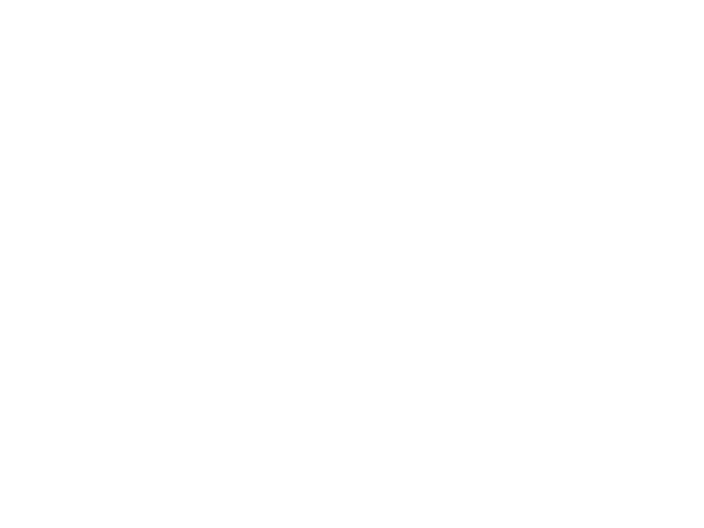

In [6]:
sigmoid_endpoints = (-5, 5)
sigmoid_bias = 2
sigmoid_weight = 1
sigmoid_test_values = np.linspace(sigmoid_endpoints[0], sigmoid_endpoints[1], 20) 
sigmoid_decisions = sigmoid_classify(sigmoid_test_values, sigmoid_weight, sigmoid_bias)

sigmoid_fig, sigmoid_ax = plt.subplots()

# Plot activation function as a step function
#
sigmoid_ax.plot(sigmoid_test_values, sigmoid_decisions)

# The next line simply changes the colors based on
# the function values.
#
sigmoid_cmap, sigmoid_norm = mcolors.from_levels_and_colors(
    [
        sigmoid_endpoints[0],
        sigmoid_bias,
        sigmoid_endpoints[1]
    ],
    [
        'red',
        'green'
    ]
)

sigmoid_ax.scatter(sigmoid_test_values, np.round(sigmoid_decisions),
                   c=sigmoid_test_values, cmap=sigmoid_cmap, norm=sigmoid_norm)

sigmoid_fig.show()

## Learning an Activation Function

We conclude this notebook by bringing our sigmoid activation function into the context of machine learning by way of this notebook's exercise.

Given a particular data set which is labeled with a "yes" or "no" decision for each data point, we'd like to determine which activation function matches that data set as closely as possible. Our sigmoid activation function contains two parameters (the _weight_ and _bias_ terms) which 

Recall that for a collection of measured values $x_i$ and model predictions $\bar{x_i}$, the Mean Squared Error function is given by:

$$ 
\begin{align*}
    L &= \frac{1}{n}\sum\limits_{i=0}^{n}{\left( \bar{x_i} - x_i \right)^2} \\
      &= \frac{1}{n}\sum\limits_{i=0}^{n}{\left( \sigma(x_i) - x_i \right)^2}
\end{align*}
$$

To find the gradient of $L$ with respect to $w$ and $b$, we will to first calculate the partial derivatives $\frac{\partial{L}}{\partial{w}}$ and $\frac{\partial{L}}{\partial{b}}$, and substitute the result of that calculation into the code below to use gradient descent to determine the best-fitting sigmoid function for a particular data set.

<IPython.core.display.Javascript object>


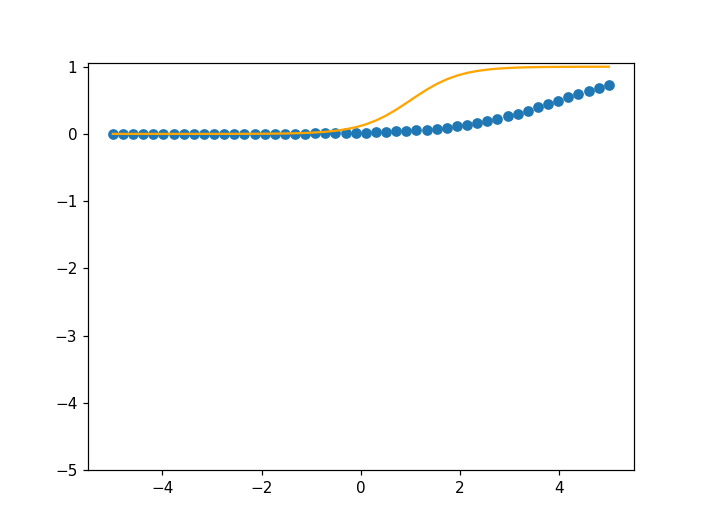

We converged to our specified tolerance in 0 iterations!


In [7]:
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots()

left_xlim = -5
right_xlim = 5

known_weight = 1
known_bias = 4

x = np.linspace(left_xlim, right_xlim, 50)[:, np.newaxis]
y = sigmoid_classify(x, known_weight, known_bias)
ax.scatter(x, y)

# Initial guess at weight and bias for our optimal sigmoid function
w = 2
b = 2

# This is where you should encode the gradient of your loss function.
#
def calculate_gradient(weight, bias, x_vals, y_vals):
    # Calculate the sigmoid activation function gradient
    #
    abs_error = 0
    d_weight = 0
    d_bias = 0
    
    # Calculate mean standard error value
    #
    mse = np.sum(np.power(abs_error, 2)) / len(x_vals)
    
    return (d_weight, d_bias, mse)
    
dw, db, err = calculate_gradient(w, b, x, y)
convergence_error_threshold = 0.1
y_predicted = sigmoid_classify(x, w, b)
z, = ax.plot(x, y_predicted, color='orange')

ax.set_ylim(bottom=-5)

acceptable_min_gradient = 0.01

for i in range(1000):
    if max(abs(dw), abs(db)) < acceptable_min_gradient:
        print('We converged to our specified tolerance in {} iterations!'.format(i))
        break
        
    theta_1 = theta_1 - (learning_rate * dtheta_1)
    theta_2 = theta_2 - (learning_rate * dtheta_2)
    
    dw, db, err = calculate_gradient(w, b, x, y)
    y_predicted = sigmoid_classify(x, w, b)
    
    z.set_ydata(y_predicted)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    # Comment out this line if you want to see how quickly your loss function converges.
    time.sleep(0.05)